## New here? This working oceanography notebook includes 'learner notes'


You might want to skip down to **Introduction**. Basics of Python and Jupyter
not included so if needed: A good option is to start 
[here](https://rabernat.github.io/research_computing/python.html).


### Next steps


* Casts, ARGO, map, MODIS on map
* Can .plot.scatter() be used to animate a scatter chart?
* Ascent versus Descent scatter chart in relation to y = x
* Mean / variance of chlorophyll with depth over time (also by time of day)
* Incorporate cmocean colormaps


### Cabled Array Sites with shallow profilers


```
Site                    Lat               Lon
------------------      ---               ---
Oregon Offshore        44.37415        -124.95648
Oregon Slope Base      44.52897        -125.38966 
Axial Base             45.83049        -129.75326
```   


### MODIS 


- Have in hand: OSB surface chlorophyll
  - June-September 2019, ~13 observations separated by 8 day intervals
  - Other locations? Time ranges? 
  - native pixels are at most 1 km; wheareas surface chlorophyll is 1/2 to 1 deg?

# Introduction


This notebook compares profiler chlorophyll measurements to surface chlorophyll observations by the 
MODIS satellite. The profiler operates in the upper 200 meters of the ocean off the coast of Oregon. 
It is maintained by the Regional Cabled Array program as part of the Ocean Observing Initiative.
The first part of this notebook concerns getting profiler data using a Python package called **yodapy**;
so let's start there and let the other facets of this work come into focus as we proceed. 


`yodapy` is a contraction of **Y**our **O**cean **DA**ta **PY**thon library. It was written 
by Don Setiawan to facilitate working with **OOI** data. Before `yodapy` was written we were 
obliged to manually follow a sequence of mysterious steps to get data of interest from OOI. 
Now by using the `yodapy` Python library we can search for, identify, order and download data 
*from within a block of code*, voila this notebook. 


This notebook reviews `yodapy` specific to the Regional Cabled Array (RCA) and as noted
measurements of chlorophyll in the upper water column (the photic zone). However the methods
and skills presented here are relevant to othe types of data and 
to other OOI segments. 


One other point before we begin: The OOI system requires you to *authenticate* as a sort of 
customer so you'll need to go register at their website. There is no cost and it only takes 
a couple of minutes. 


## Notebook features

- Walk-through: Locating, ordering, and downloading data from OOI: Uses `yodapy`
  - focus on the Regional Cabled Array (RCA)
  - data are in NetCDF format, a good match to `xarray` 
- demonstrate working with `xarray` `DataArrays` and `Datasets` 
- demonstrate plotting with `matplotlib`
  - line and scatter plots, multiple y-axes, labels, marker type and size
  - profiler curtain plots: time - depth - chlorophyll (as color) 
  - animation

***Run the following Python cells: Perfunctory configuration***

In [1]:
# Ensure that the latest build of yodapy is installed directly from github using
!pip install git+https://github.com/cormorack/yodapy.git -q     # -q cuts the stdout clutter

In [2]:
!pip install cmocean

  Using cached https://files.pythonhosted.org/packages/48/02/d0f19b00b252fd972e3daec05be73aa811091528f21b90442a15d6a96d89/cmocean-2.0-py3-none-any.whl


In [3]:
!conda install -c conda-forge ffmpeg -y -q                                       # -y skips dialogs; -q reduces stdout clutter

Solving environment: ...working... done

## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - ffmpeg


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    certifi-2019.11.28         |           py37_0         148 KB  conda-forge
    ffmpeg-4.2                 |       h167e202_0        80.2 MB  conda-forge
    gmp-6.1.2                  |    hf484d3e_1000         751 KB  conda-forge
    gnutls-3.6.5               |    hd3a4fd2_1002         2.1 MB  conda-forge
    lame-3.100                 |    h14c3975_1001         498 KB  conda-forge
    nettle-3.4.1               |    h1bed415_1002         5.7 MB  conda-forge
    openh264-1.8.0             |    hdbcaa40_1000         1.4 MB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
   

In [5]:
from matplotlib import pyplot as plt
from matplotlib import colors as mplcolors   # map data values to colors
from matplotlib import animation, rc

# Note that !which ffmpeg returns /srv/conda/envs/notebook/bin/ffmpeg
plt.rcParams['animation.ffmpeg_path'] = '/srv/conda/envs/notebook/bin/ffmpeg'    # matplotlib must see the movie writer 'ffmpeg'

from IPython.display import HTML

import numpy as np
from numpy import datetime64 as dt64, timedelta64 as td64

import xarray as xr

# for installing slider controllers and so forth... uncomment these two lines
# from ipywidgets import *
# from traitlets import dlink

# Local application/library specific imports
from golive_library import GoliveLibrary as g

# to learn yodapy set this to True
learn_yodapy = False

### Skip ahead?

If you are returning to this notebook to continue prior work you have two skip ahead options at this point:

* Skip to **(Skip-to-here point) Create a `yodapy` OOI instance** to continue working the data browse/order process
* Skip to **(Skip-to-here point) MODIS Intermezzo** if your data is already in place in this Jupyter environment


First time through? Run the next cell...

- ... to verify that `yodapy` installed properly above
- ... to get ready to configure your OOI credentials

In [5]:
if learn_yodapy: from yodapy.utils.creds import set_credentials_file

## Configuring `yodapy`


### OOI data access back-story


To order data from **OOI** requires you to pre-register (free, uses your email address). This provides you 
credentials when placing a data order. Orders typically take a few minutes for the OOI
servers to assemble; after which you receive an email with a download link. You download the data to local storage
and read files into memory and proceed from there, a very labor-intensive process.


### How `yodapy` helps


[`yodapy`](http://github.com/cormorack/yodapy) helps you automate OOI data access at each step. 
It sets up a credentials directory within your home directory;
and in so doing helps you avoid accidentally pushing your credentials to `github` where they would be public. `yodapy` 
allows you to create a Python object called an `OOI()` that includes methods for finding sensor data of interest; 
for ordering time-bounded datasets for those sensors; for downloading this data; and for attaching it to a data 
structure (an `xarray Dataset`) for further analysis. It is at this point when you have your data present as a 
`Dataset` that `yodapy` has completed its job. 


The next cell installs `yodapy`. Run this each time you start up this notebook server unless your installation
of the `yodapy` library persists. 


### Getting OOI credentials


To get data from OOI you first create a User account as follows:


- Visit the [OOI website](https://ooinet.oceanobservatories.org/#)
- On the login menu (upper right) select **Register**
- Fill out the New User Registration Form
- Once you have your login credentials: Log in
- The 'Login' menu should be replaced with your User name at the upper right: Also a dropdown menu
  - Use this menu to select User Profile
- At the bottom of your User Profile page you should find **API Username** and **API Token**
  - These two strings comprise your authentication 
  - Keep them somewhere safe
  - Notice that the **Refresh API Token** button permits you to regenerate them whenever you like


Use your OOI API Token with `yodapy` as described further down to automate your authentication process.
If this works as intended you can safely use OOI and not have to worry about cutting and pasting these
token strings every time you want to get data access.

### Set up your *local* OOI credentials using `yodapy`


Only the first time through here: Carefully follow the instructions in the Python cell below.
You are (temporarily) telling `yodapy` what your `OOI username` and `token` are. 
`yodapy` creates a hard-to-notice sub-directory of your home directory
that contains these credentials in a text file. As long as you are not publishing
your home directory someplace public your credentials will be hidden away.


#### 'Why am I doing this?'


When you use `yodapy` to order data from OOI it will use this 'hidden away' copy
of your credentials to convince OOI your order is legitimate.  

In [6]:
# Run the next line of code to create authentication credentials for the OOI data system. Do this
# by ***carefully**** substituting your actual credentials in the username and token strings
# in this line of code:


# set_credentials_file(data_source='ooi', username='OOIAPI-XXXXXXXXXXXXXX', token='XXXXXXXXXXXX')


# Un-comment the code and run the cell, just the one line above.
# Once it runs: Comment it out again and delete your credentials. You can obscure them with XXXXX as they are seen now.
# After you obscure your credentials: Be sure not to run this code again as it will break your authentication info.
#
# You can verify this worked by examining the .credentials file in ~/.yodapy. The credentials should match. Notice that 
#   this (slightly hidden) directory is directly connected to your home directory; whereas this IPython notebook 
#   is presumably in a distinct directory; so there should be no chance of a GitHub push sending your 
#   credentials to GitHub. 

## (skip-to-here point) Create a `yodapy` OOI instance

The ooi instance will enable you to connect to data resources and get datasets. 

In [7]:
if learn_yodapy: 
    from yodapy.datasources import OOI
    ooi = OOI()
    g.dirnou(ooi)

# Run this to see all the components or segments of OOI available
# ooi.sites

In [8]:
# We can explore these methods and attributes further. Note that yodapy has a series of 
# attributes that begin with 'cava_'. 'cava' is shorthand for "cabled array value add", 
#   a project at the University of Washington School of Oceanography supporting cabled array
#   data validation and use in ocean research.
# help(ooi.cava_sites)
if learn_yodapy: print(ooi.cava_sites, '\n\n\n', ooi.cava_parameters)

## `ooi.search()` first example


We will begin using `yodapy` proper to narrow down a data search. 


### What resources are available?


Specifically what are the names of sites served by the Regional Cabled Array? 
We begin with a broad search giving only the keyword `region`. 
Then we narrow the search by adding including keywords `site`, `node`, and `instrument` 
to arrive at individual *instruments* or *sensors*. These search results are used to order 
datasets with a specified time range. 


This first example is the broad search. 

In [9]:
if learn_yodapy: 
    # ooi.search(region='endurance')
    ooi.search(region='cabled')

In [10]:
if learn_yodapy: 
    # Attribute 'sites' gives broad results as a table of arrays, sites, descriptions, lat/lon: Across all of OOI (62 rows)
    ooi.sites        

In [11]:
if learn_yodapy: 
    # Narrow result: Within the Cabled Array region only (116 rows, 6 named columns)
    ooi.instruments

## The notion of a refined OOI search in `yodapy`


The `OOI()` object provided by `yodapy` starts out in a very *broad view* state. It "knows about" the entire OOI: 
Endurance, Pioneer, Argentine Basin, the Cabled Array, Irminger Sea, Station Papa and so on. 


When we use the `.search()` method with keywords we are in effect narrowing down what the `OOI()` object knows 
about. In this code the `OOI()` object is called `ooi` so a search looks like `ooi.search(keyword = 'search string', etc)`. 
After this runs the internal state of `ooi` changes to reflect the search results: It knows about less.


Once we have found a very specific search result of interest the `ooi` object can issue a data request 
using `ooi.request_data(...args...)`.  This data request will use the narrowed-down search perspective 
so as not to order extraneous data. Ideally each data request is focused on only one instrument. This 
helps organize data access within the code.

## `ooi.search()` second example

We narrow the search using keywords `site`, `node` and `instrument`. 
The `ooi.instruments` result from above provides the vocabulary to use for keyword arguments: 

- `site` keyword is taken from the `site_name` column
  - for example `Oregon Slope Base Seafloor` suggests using `oregon slope base` as the keyword value
- `node` keyword is taken from the `infrastructure_name` column
  - for example 'Shallow Profiler (SF01A)` suggests keyword `shallow profiler` (notice these are not case-sensitive)
- `instrument` keyword is taken from the `instrument_name` column
  - for example `3-Wavelength Fluorometer` suggests keyword `fluorometer`
  


Once the narrow search runs we look at the `ooi.instruments` attribute to see how narrow the results are.
This prints as a table where -- as in example one -- the results are sorted into *one instrument per row*.
This can confirm whether the objective of narrowing the search down to a single instrument was met.


We run the `.data_availability()` method. This gives two outputs: A **table** and below that a 
**time series graphic**.  The table lists each instrument as a separate column. These columns are 
then transposed for the time series graphic: One row of boxes for each instrument. 


***Detail: The green `.data_availability()` chart may fail to render in some cases. Re-running the cell might help.***


In [12]:
if learn_yodapy: 
    ooi.search(region='endurance', site='oregon offshore', node='shallow profiler', instrument='fluorometer')

In [13]:
if learn_yodapy: 
    ooi.instruments

In [14]:
if learn_yodapy: 
    ooi.data_availability()

In [15]:
# run this to see fluorometers available at Oregon Offshore (without using the 'node' keyword)
# 
#   filters endurance + oregon offshore + fluorometer turn up 7 hits...
#     2 are Oregon Offshore Surface Mooring: 3 wavelength... of future interest in expanding the MODIS connection
#     2 are Oregon Offshore deep profiler CDOM fluorometer
#     2 are Oregon Offshore deep profiler 2 wavelength...    of future interest also (not sure if this is on the RCA)
#     1 is Oregon Offshore shallow profiler 3 wavelength     *** Current interest: RCA MODIS connect ***
#
# ooi.search(region='endurance', site='oregon offshore', instrument='fluorometer')
# ooi.instruments
# ooi.data_availability()

In [16]:
# This ooi.search() call: 
# 
# ooi.search(region='cabled', instrument='fluorometer') 
# 
# produces 12 hits. Here is the breakdown; where results suggest site and node search keywords. 
#  Note that Deep Profiler sites have degeneracy in 'recovered_inst' versus 'recovered_wfp' (appear twice)
# 
#     - (4) Axial Base Deep Profiler Mooring (CDOM Fluorometer,  2-Wavelength Fluorometer)
#     - (4) Oregon Slope Base Deep Profiler Mooring (CDOM Fluorometer, 2-Wavelength Fluorometer)
#     - (1) Oregon Slope Base Shallow Profiler Mooring (200m Platform; 2-Wavelength Fluorometer)
#     - (1) Oregon Slope Base Shallow Profiler Mooring (Shallow Profiler; 3-Wavelength Fluorometer)
#     - (1) Axial Base Shallow Profiler Mooring (200m Platform; 2-Wavelength Fluorometer)
#     - (1) Axial Base Shallow Profiler Mooring (Shallow Profiler; 3-Wavelength Fluorometer)

# Resulting searches: Choose one of these...
if learn_yodapy: 
    ooi.search(region='cabled', site='oregon slope base', node='shallow', instrument='fluorometer')
# ooi.search(region='cabled', site='oregon slope base', node='200m', instrument='fluorometer')
# ooi.search(region='cabled', site='axial base', node='shallow', instrument='fluorometer')
# ooi.search(region='cabled', site='axial base', node='200m', instrument='fluorometer')

# ...and run...
if learn_yodapy: 
    ooi.data_availability()

## transition to data request

The following cells include code for requesting data from OOI. From this point onward the 
narrative will be less detailed. 

In [17]:
# Assume the above cell narrowed the search results to a single instrument. Assume also that we 
#   are interested in June 1 -- September 15 of 2019. We now use the ooi object to generate a 
#   data request.
#
# .request_data() generates a data request
# .to_xarray() polls the OOI system until the order completes; this will take a couple of minutes
#
# begin_date = '2019-06-01'
# end_date = '2019-09-15'
# ooi.request_data(begin_date=begin_date, end_date=end_date)
# ds = ooi.to_xarray()
# len(ds)

In [18]:
# run this to download the data (possibly multiple files) from a completed data request from above
# 
# filenamelist = ooi.download_netcdfs()
# len(filenamelist)

### Two intermezzos follow

- Managing (hundreds of MB) datasets in this Jupyter environment
- Bring in surface chlorophyll data from the MODIS satellite


## Data management intermezzo


### What is the issue here? 


This narrative is provided as an IPython notebook (really a Jupyter notebook) which resides in 
a Linux sub-directory of the User home directory `~`. This sub-directory is bundled using
the `git` utility as an open source repository ('repo') backed up by 
[`github`](https://github.com/robfatland/chlorophyll).
The github service constrains repository size with the idea of backing up code, not data. 


So far so good. The data considered here exceeds 1GB and needs to be placed elsewhere in the 
working environment; in fact within a `data` sub-directory not part of the `chlorophyll`
repo. We outline one approach for doing this here using the Linux command line, available
through a terminal window provided in the Jupyter environment. 



#### File resources


The code above pulls NetCDF files to a local `chlorophyll` repository directory. 
In practice this `github` repository directory does not have capacity for 
large data files (hundreds of MB). To deal with this (at the moment) we relocate 
the data files outside the repository and access them by creating symbolic 
links. Here is a sketch of the directory structure:


```
home directory ~ has sub-directories:

.yodapy                    chlorophyll                    data

(OOI credentials)          (IPython notebooks)            sub-dir 'chlorophyll'

                                                              sub-dir 'OregonSlopeBase'
                                                          
                                                                  sub-dir 'ShallowProfiler'
                                                          
                                                                      ...includes 730MB of data
```


The symbolic link command looks like this, noting the distinction between `chlorophyll`
as a sub-directory of `data` versus `chlorophyll` as the repository directory:


```
ln -s ~/data/chlorophyll/SiteDir/InstrumentDir/filename.nc ~/chlorophyll/Identifier_00XX.nc
```


The code uses the `xarray` (multi-file) `xr.open_mfdataset("Identifier*.nc")` Dataset generator to 
open possibly multiple files as a single `Dataset`. 


These data are (upon arrival) ordered under dimension = observation number `obs`.
The data are immediately modified to use dimension = `time`.


Here is the current state of data holdings in this environment:


```
SymLink                                 Site               Instrument  Sensor        Got it
-----------                             ---------          ----------  ---------     ---------
OreOff_ShallProf_Fluor_000*.nc          Oregon Offshore    shallow     fluor chlor     X        

OreSlope_ShallProf_Fluor_000*.nc        Oregon Slope Base  shallow     fluor chlor     X  
OreSlope_200m_Fluor_000*.nc             Oregon Slope Base  200m        fluor chlor     X

AxialBase_ShallProf_Fluor_000*.nc       Oregon Slope Base  shallow     fluor chlor     X
AxialBase_200m_Fluor_000*.nc            Oregon Slope Base  200m        fluor chlor     not yet
AxialBase_DeepProf_Fluor_000*.nc        Oregon Slope Base  deep        fluor chlor     not yet
```


## (Skip-to-here point) MODIS intermezzo 


#### This section builds an `xarray Dataset` by hand from a small set of data points.


At this point having ordered data and placed it nearby we are done using `yodapy`.
From here on we focus on `xarray`, `matplotlib` and other Python utilities. 


MODIS estimates of surface chlorophyll at the Oregon Slope Base site are provided
by Sarah Barnes and Derya Gumustel. (link to their nbk here) There are a dozen or so valid
observations in summer 2019. 





In [6]:
# This code constructs a MODIS observation DataArray from two lists: A date list and a data list.
#   Additional code demonstrates working with this DataArray and subsequently an xarray Dataset.

# MODIS dates of observation
mdate = [dt64('2019-06-02T11:15:00.0'), \
         dt64('2019-06-10T11:55:01.0'), \
         dt64('2019-06-18T11:15:00.0'), \
         dt64('2019-06-26T11:55:01.0'), \
         dt64('2019-07-04T11:15:00.0'), \
         dt64('2019-07-12T11:55:01.0'), \
         dt64('2019-07-20T11:15:00.0'), \
         dt64('2019-07-28T11:55:01.0'), \
         dt64('2019-08-05T11:15:00.0'), \
         dt64('2019-08-13T11:55:01.0'), \
         dt64('2019-08-21T11:15:00.0'), \
         dt64('2019-08-29T11:55:01.0')]

# MODIS corresponding surface chlorophyll estimates
mchl = [0.3483194, 0.49131608, 0.48018616, np.nan, np.nan, 0.2037715, 0.26320615, 0.3066225, \
        0.35098818, 0.579521, 0.67963886, 0.58974856]

# Translating these two lists into a MODIS DataArray
mda = xr.DataArray(mchl, dims=('time'), coords={'time': mdate})
mda

<xarray.DataArray (time: 12)>
array([0.348319, 0.491316, 0.480186,      nan,      nan, 0.203771, 0.263206,
       0.306623, 0.350988, 0.579521, 0.679639, 0.589749])
Coordinates:
  * time     (time) datetime64[ns] 2019-06-02T11:15:00 ... 2019-08-29T11:55:01

In [7]:
# Given this DataArray: Provide an example of retrieving the numerical data values.
#   Noting that the .values attribute provides an array of floats
print(mda.values)
print()
print(mda.values[0])
print()
print('The mean of the numerical values is ' + "%5.3f" % mda.values[~np.isnan(mda.values)].mean())

[0.3483194  0.49131608 0.48018616        nan        nan 0.2037715
 0.26320615 0.3066225  0.35098818 0.579521   0.67963886 0.58974856]

0.3483194

The mean of the numerical values is 0.429


#### deconstructing that last print statement above


In the preceding code block the final `print()` is a bit dense so let's deconstruct it.


- `"%5.3f" % x` is a format statement for printing a float value `x` with three decimal places. 
- `mda.values` is a `numpy ndarray` (not a list) of the chlorophyll estimates from MODIS. 
  - A `DataArray` is thematically just one type of data
- `np.isnan(...ndarray...)` is also of type `numpy ndarray`, in this case boolean `True` or `False` values
  - `True` means the corresponding DataArray element is a `nan`; no valid data present
- `~np.isnan(...ndarray...)` applies logical NOT to the prior result so that 'True' means 'valid data'
- `mda.values[~np.isnan(...)]` reduces `mda.values` to only valid data: The boolean array is used as a mask
- `mda.values[...].mean()` returns the mean of the reduced 'only valid data' result above

In [8]:
mda.dims

('time',)

In [9]:
mda.coords

Coordinates:
  * time     (time) datetime64[ns] 2019-06-02T11:15:00 ... 2019-08-29T11:55:01

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


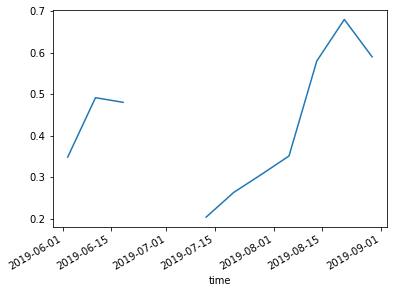

In [10]:
mda.plot()      # there is no ambiguity about what to plot as a DataArray has just one type of data

In [11]:
mds = xr.Dataset({'MODIS chlorophyll': mda})       # The DataArray is translated into a Dataset
mds.attrs['units']='µg L-1'                        # Adding units as a metadata attribute
mds

<xarray.Dataset>
Dimensions:            (time: 12)
Coordinates:
  * time               (time) datetime64[ns] 2019-06-02T11:15:00 ... 2019-08-29T11:55:01
Data variables:
    MODIS chlorophyll  (time) float64 0.3483 0.4913 0.4802 ... 0.6796 0.5897
Attributes:
    units:    µg L-1

### MODIS surface chlorophyll 
#### Summer 2019, over the Regional Cabled Array off Oregon coast

In sequence: June 18, July 20, August 21, 2019.

<BR>
<img src="./MODIS_chlorophyll_18JUN2019.png" style="float: left;" alt="drawing" width="550"/>
<div style="clear: left"><BR>

<BR>
<img src="./MODIS_chlorophyll_20JUL2019.png" style="float: left;" alt="drawing" width="550"/>
<div style="clear: left"><BR>

<BR>
<img src="./MODIS_chlorophyll_21AUG2019.png" style="float: left;" alt="drawing" width="550"/>
<div style="clear: left"><BR>



### Section on Cabled Array Oregon Slope Base fluorometer-derived chlorophyll data

Multiple local data files can be opened at this point as a single Dataset using `xarray`:

```
ds=xr.open_mfdataset(...filename description string...)
ds = ds.swap_dims({'obs':'time'})
```

This swaps out observation number in favor of time as the operative dimension. 

In [12]:
# This version uses wildcard notation on pre-existing data files
# Endurance array 'Oregon Offshore' site data, 200 meter platform at Oregon Slope Base, Axial Base shallow profiler
#   ds = xr.open_mfdataset('/home/jovyan/chlorophyll/OreOff_ShallProf_Fluor_000*.nc')
#   ds = xr.open_mfdataset('/home/jovyan/chlorophyll/OreSlope_200m_Fluor_000*.nc')
#   ds = xr.open_mfdataset('/home/jovyan/chlorophyll/AxialBase_ShallProf_Fluor_000*.nc')

# Cabled Array 'Oregon Slope Base' site data:
ds = xr.open_mfdataset('/home/jovyan/chlorophyll/OreSlope_ShallProf_Fluor_000*.nc')
ds = ds.swap_dims({'obs':'time'})
ds

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


<xarray.Dataset>
Dimensions:                                          (time: 7202071)
Coordinates:
    obs                                              (time) int64 0 ... 6250485
  * time                                             (time) datetime64[ns] 2019-06-01T00:00:00.339009024 ... 2019-09-14T23:59:59.135749632
    int_ctd_pressure                                 (time) float64 dask.array<shape=(7202071,), chunksize=(951585,)>
    lat                                              (time) float64 dask.array<shape=(7202071,), chunksize=(951585,)>
    lon                                              (time) float64 dask.array<shape=(7202071,), chunksize=(951585,)>
Data variables:
    deployment                                       (time) int32 dask.array<shape=(7202071,), chunksize=(951585,)>
    id                                               (time) |S36 dask.array<shape=(7202071,), chunksize=(951585,)>
    date_string                                      (time) object dask.array<sha

In [13]:
# run this to get a check of the units for chlorophyll 

ds.fluorometric_chlorophyll_a.units

# one can make a quick plot of (say) the chlorophyll with time via
# p = ds.fluorometric_chlorophyll_a.plot()

'µg L-1'

### Section: Oregon Slope Base Shallow Profiler near-surface comparison to MODIS


The Oregon Slope Base site has a depth of about 2900 meters and is located at the base of the continental shelf 
west of Oregon. The fluorometer data are collected over the course of a day as nine profile runs from a depth
of 200 meters to near the surface. Between profiles that profiler pod is at rest on a platform that is always
at a depth of 200 meters. The sampling rate is a little less than on sample per second. 


The objective in this section is to create an approximate record of near-surface chlorophyll (all measurements 
above say 25 meter depth) and compare that with the MODIS values for the same site. 

In [14]:
ds.dims

Frozen(SortedKeysDict({'time': 7202071}))

In [15]:
ds.coords

Coordinates:
    obs               (time) int64 0 1 2 3 4 ... 6250482 6250483 6250484 6250485
  * time              (time) datetime64[ns] 2019-06-01T00:00:00.339009024 ... 2019-09-14T23:59:59.135749632
    int_ctd_pressure  (time) float64 dask.array<shape=(7202071,), chunksize=(951585,)>
    lat               (time) float64 dask.array<shape=(7202071,), chunksize=(951585,)>
    lon               (time) float64 dask.array<shape=(7202071,), chunksize=(951585,)>

Run `ds.time[0:20], ds.time[-20:-1]`
to see example timestamps at the start and end of the Dataset.

The following code produces timedelta64 results from datetime64 values. 
The `.item()` method copies an ndarray element to a scalar and returns that scalar.
With no arguments `.item()` is converting a single-element array into a scalar.
All three lines of code return 1.128 seconds as the interval between samples.

```
(ds.time[1].values-ds.time[0].values).item()*1.e-9             # inter-sample interval in seconds
(ds.time[-1].values-ds.time[-2].values).item()*1.e-9           # and the same at the end; same result
(ds.time[1901000].values-ds.time[1900000].values).item()*1.e-9*1.e-3           # longer interval
```

Latitude and longitude are fixed.

```
print(len(ds.lat))
ds.lat[3000000:3000007].values       # fixed: the sensor does not move horizontally (much)
```

In [16]:
# dss is Dataset subset: using where() to select for the shallow depth range, "above so-many meters"
#
# < 25 gives 383k points
# < 20 gives 278k points
# < 15 gives 144k points
# < 10 gives 44k points 

dss=ds.where(ds.int_ctd_pressure < 25., drop=True)    # dss is a Dataset

In [17]:
dss.dims, ds.dims

(Frozen(SortedKeysDict({'time': 383070})),
 Frozen(SortedKeysDict({'time': 7202071})))

In [18]:
chlor_a = dss.fluorometric_chlorophyll_a
print(type(chlor_a))                         # will be a DataArray
pressure = dss.int_ctd_pressure
# t0 = dt64('2019-06-15T00:00')
t0 = dt64('2019-07-10T00:00')                # slightly precedes the second (contiguous) MODIS data interval
t1 = dt64('2019-09-01T00:00')
print(t0)

<class 'xarray.core.dataarray.DataArray'>
2019-07-10T00:00


In [19]:
time_x_axis = dss.time
type(time_x_axis)

xarray.core.dataarray.DataArray

In [20]:
# the .rolling() method culls out 600 consecutive values at a time; whereupon .mean() is applied
dss_chlor_mean = dss.fluorometric_chlorophyll_a.rolling(time=600, center=True).mean()

# This also works to produce locally minimal data; but it is not very interesting
# dss_chlor_min = dss.fluorometric_chlorophyll_a.rolling(time=600).min()

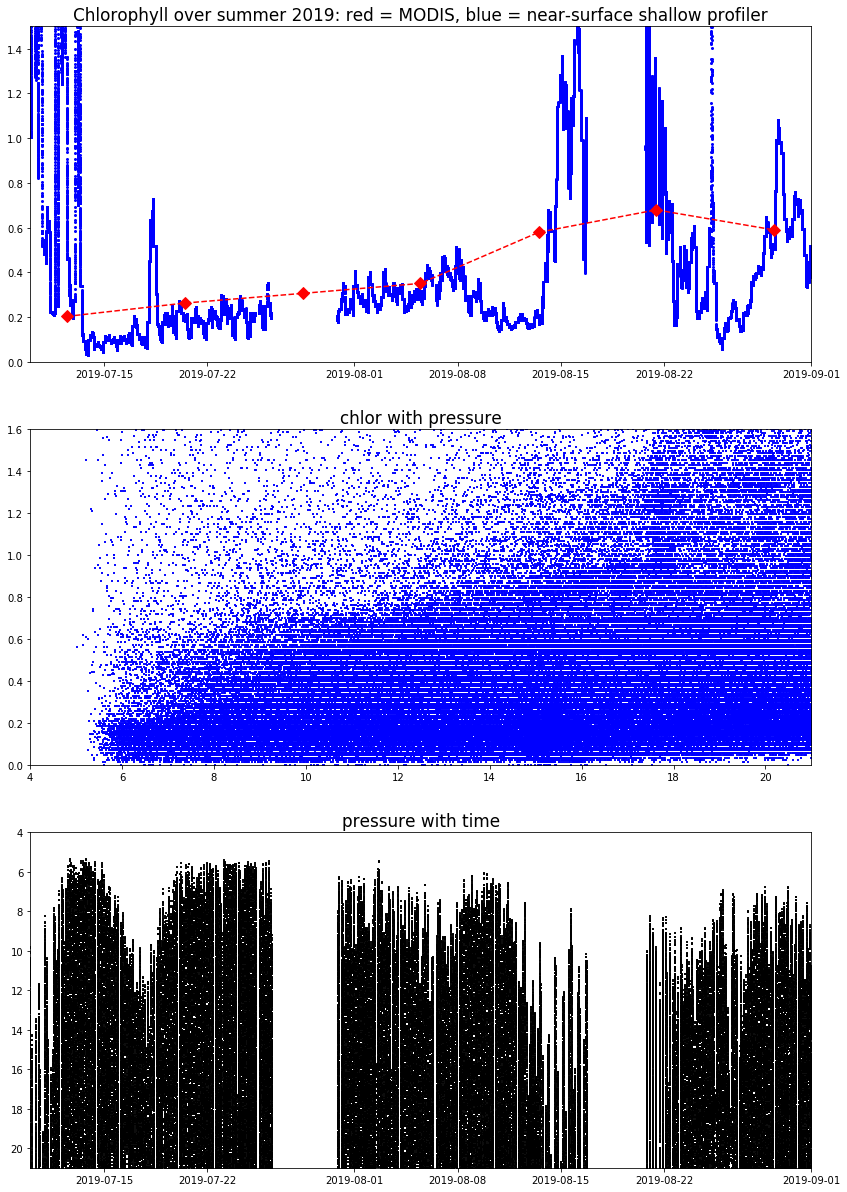

In [21]:
p,a=plt.subplots(3, 1, figsize=(14,21))
plt.rcParams.update({'font.size': 14})

# This works to produce a line plot for shallow profiler chlorophyll (rolling mean): 
# a[0].plot(time_x_axis, dss_chlor_mean, color='b')
a[0].scatter(time_x_axis.values, dss_chlor_mean, color='b', marker= 'o', s = 4.0)
a[1].scatter(pressure, chlor_a, color='b', marker= ',', s = 1.0) 
# a[2].plot(time_x_axis, pressure, color='k') 
a[2].scatter(time_x_axis.values, pressure, color='k', marker=',', s=1.0) 

a[0].set(ylim=(0., 1.5), xlim = (t0, t1), title='Chlorophyll over summer 2019: red = MODIS, blue = near-surface shallow profiler')
a[1].set(ylim=(0., 1.6), xlim = (4., 21.), title='chlor with pressure')
a[2].set(ylim=(21., 4.), xlim = (t0, t1), title='pressure with time')

a[0].plot(mda.time, mda, color='r', marker='D', markersize = 9., linestyle='dashed')
# a[0].scatter(np.datetime(mda.time), mda, color='r', marker= ',', s = 36.0)

### Section: Curtain plots of several profiler sensors

Incomplete. Missing are the lower charts and an automated means of determining the mapping range for each type of data. 

In [35]:
# This takes upwards of 10 minutes to run so I False'd it out by default

if False: 
    t0 = dt64('2019-07-10T00:00')                
    t1 = dt64('2019-09-01T00:00')

    pressure    = ds.int_ctd_pressure
    time_x_axis = ds.time
    chlor       = ds.fluorometric_chlorophyll_a
    cdom        = ds.fluorometric_cdom
    volscat     = ds.total_volume_scattering_coefficient
    temp        = ds.seawater_temperature
    salinity    = ds.practical_salinity
    seascat     = ds.seawater_scattering_coefficient
    optiback    = ds.optical_backscatter

    plt.rcParams.update({'font.size': 10})
    p,a=plt.subplots(7, 1, figsize=(20,49))

    aindex = 0
    norm = mplcolors.Normalize(vmin=0.0,vmax=0.7)
    a[aindex].scatter(time_x_axis.values, pressure, cmap='jet', c=chlor, norm=norm, marker= ',', s = 1.0)
    a[aindex].set(ylim=(200., 0.0), xlim = (t0, t1))
    plt.rcParams.update({'font.size': 14})
    a[aindex].set(title='Chlorophyll with time and depth')
    plt.rcParams.update({'font.size': 10})
    a[aindex].set_ylabel('Pressure (dbar)')
    a[aindex].set_xlabel('Date')

    aindex = 1
    norm = mplcolors.Normalize(vmin=7.0,vmax=14.)
    a[aindex].scatter(time_x_axis.values, pressure, cmap='jet', c=temp, norm=norm, marker= ',', s = 1.0)
    a[aindex].set(ylim=(200., 0.0), xlim = (t0, t1))
    plt.rcParams.update({'font.size': 14})
    a[aindex].set(title='Temperature with time and depth')
    plt.rcParams.update({'font.size': 10})
    a[aindex].set_ylabel('Pressure (dbar)')
    a[aindex].set_xlabel('Date')

    aindex = 2
    norm = mplcolors.Normalize(vmin=7.0,vmax=14.)
    a[aindex].scatter(time_x_axis.values, pressure, cmap='jet', c=optiback, norm=norm, marker= ',', s = 1.0)
    a[aindex].set(ylim=(200., 0.0), xlim = (t0, t1))
    plt.rcParams.update({'font.size': 14})
    a[aindex].set(title='Optical backscatter with time and depth')
    plt.rcParams.update({'font.size': 10})
    a[aindex].set_ylabel('Pressure (dbar)')
    a[aindex].set_xlabel('Date')

    aindex = 3
    norm = mplcolors.Normalize(vmin=7.0,vmax=14.)
    a[aindex].scatter(time_x_axis.values, pressure, cmap='jet', c=salinity, norm=norm, marker= ',', s = 1.0)
    a[aindex].set(ylim=(200., 0.0), xlim = (t0, t1))
    plt.rcParams.update({'font.size': 14})
    a[aindex].set(title='Salinity with time and depth')
    plt.rcParams.update({'font.size': 10})
    a[aindex].set_ylabel('Pressure (dbar)')
    a[aindex].set_xlabel('Date')

### Section: Expanded chlorophyll curtain plots

Treats the below-100-meters and above-100-meters as two separate colormap tasks. 

Text(0.5, 0, 'Date')

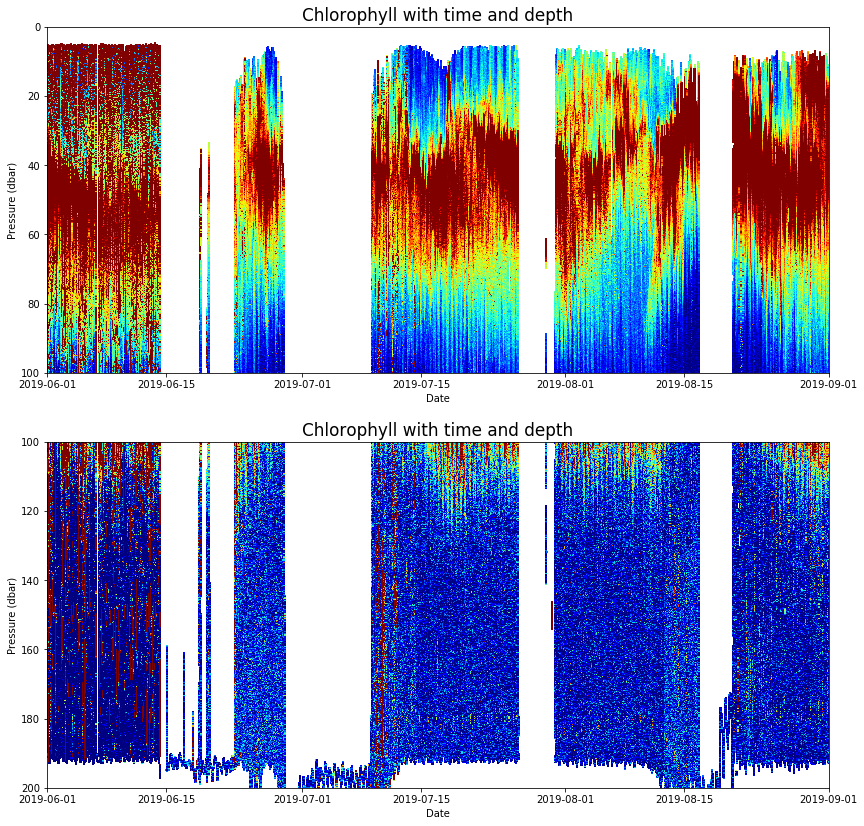

In [36]:
from matplotlib import colors as mplcolors

t0 = dt64('2019-06-01T00:00')                
t1 = dt64('2019-09-01T00:00')

pressure = ds.int_ctd_pressure
time_x_axis = ds.time
chlor = ds.fluorometric_chlorophyll_a


plt.rcParams.update({'font.size': 10})
p,a=plt.subplots(2, 1, figsize=(14,14))

norm = mplcolors.Normalize(vmin=0.0,vmax=0.5)
a[0].scatter(time_x_axis.values, pressure, cmap='jet', c=chlor, norm=norm, marker= ',', s = 1.0)
a[0].set(ylim=(100., 0.0), xlim = (t0, t1))
plt.rcParams.update({'font.size': 14})
a[0].set(title='Chlorophyll with time and depth')
plt.rcParams.update({'font.size': 10})
a[0].set_ylabel('Pressure (dbar)')
a[0].set_xlabel('Date')

norm = mplcolors.Normalize(vmin=0.0,vmax=0.1)
a[1].scatter(time_x_axis.values, pressure, cmap='jet', c=chlor, norm=norm, marker= ',', s = 1.0)
a[1].set(ylim=(200., 100.0), xlim = (t0, t1))
plt.rcParams.update({'font.size': 14})
a[1].set(title='Chlorophyll with time and depth')
plt.rcParams.update({'font.size': 10})
a[1].set_ylabel('Pressure (dbar)')
a[1].set_xlabel('Date')

### Section: Double chlorophyll lens July 20 2019 (3 profiles) 


We can ask whether the recorded signal is a mirror image as the profiler rises and falls. To see this
it helps to have a double-y-axis as shown in [this example](https://matplotlib.org/gallery/api/two_scales.html). 


Below we have three consecutive profiles over the course of seven hours which all demonstrate a double-maximum
in chlorophyll concentration: One at about 30 meters and another at about 55 meters. 


In [37]:
# 
# Precision section works with precise times versus day-scale
#   The precise times are an experiment in using 2 hours 40 minutes to chop up the 9 profiles in the day in a regular manner...
#   but a better approach would be to detect the profiles and time-box each one individually. 
# 

t0 = dt64('2019-07-20T11:00')
t1 = dt64('2019-07-20T18:00')
dss = ds.sel(time=slice(t0, t1))
len(dss.time)

21000

[(200.0, 0.0), Text(0.5, 1.0, '   ')]

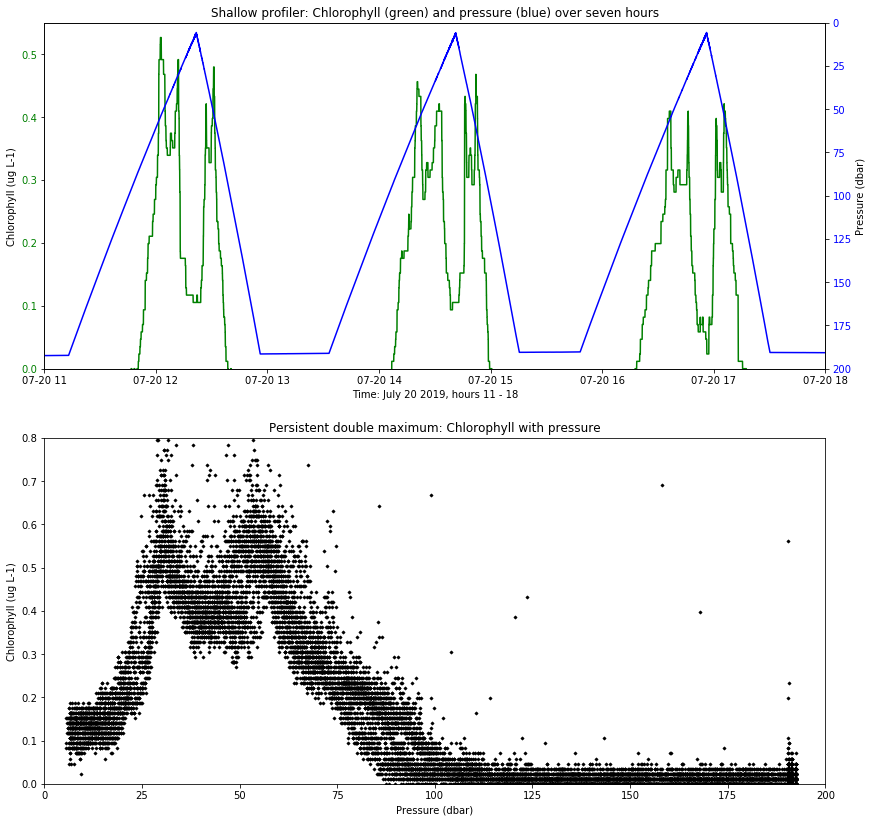

In [38]:
p,a=plt.subplots(2, 1, figsize=(14,14))
plt.rcParams.update({'font.size': 10})
chlor_a = dss.fluorometric_chlorophyll_a
chlor_a_min = chlor_a.rolling(time=60, center=True).min()
pressure = dss.int_ctd_pressure

a[0].plot(dss.time, chlor_a_min, color='g')
a[1].scatter(pressure, chlor_a, color='k', marker= 'D', s = 4.0) 

a[0].set(ylim=(0., 0.55), xlim = (t0, t1), title='Shallow profiler: Chlorophyll (green) and pressure (blue) over seven hours')
a[1].set(ylim=(0., 0.8), xlim = (0., 200.), title='Persistent double maximum: Chlorophyll with pressure')

a[0].set_ylabel('Chlorophyll (ug L-1)')
a[0].set_xlabel('Time: July 20 2019, hours 11 - 18')
a[0].tick_params(axis='y', labelcolor='green')

a[1].set_ylabel('Chlorophyll (ug L-1)')
a[1].set_xlabel('Pressure (dbar)')
a[1].tick_params(axis='y', labelcolor='k')

a0p = a[0].twinx()
a0p.set_ylabel('Pressure (dbar)')
a0p.plot(dss.time, pressure, color='blue')
a0p.tick_params(axis='y', labelcolor='blue')
a0p.set(ylim=(200., 0.), title='   ')

# Optional formatting code: p.tight_layout()

### Section: Animating of chlorophyll depth profiles

From August 1 to August 15 2019 we have 9 profiles per day of the water column at the Oregon Slope Base site.  
The objective here is to animate these 135 profiles: Depth on the y-axis and chlorophyll concentration on 
the x-axis. Each frame of the animation is a single profile featuring both rise and descent tracks. 

* [JS Animation in Jupyter notebooks 2nd blog post (update to original)](http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/)
* `HTML(anim.to_html5_video())` generates the animation with minimal controls (including download)
* `HTML(anim.to_jshtml())` generates the animation with several playback controls


*ffmpeg* installation is necessary: `conda install -c conda-forge ffmpeg`


##### In both cases I get a static view below the animated one, a bug

##### Steps

1. Define chart parameters
2. Define initialization and animation functions
3. Instantiate an animation object
4. Generate the animation

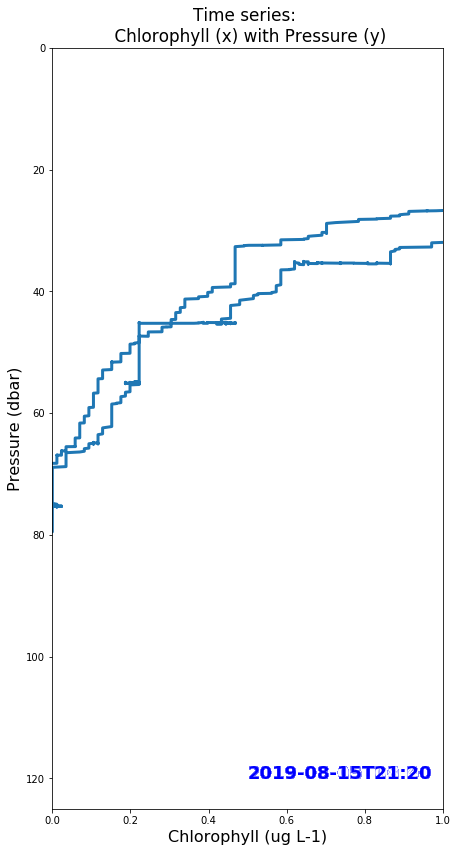

In [39]:
# 1. Chart setup
fig, ax = plt.subplots(figsize=(7,14))     # creates a vertically elongated chart (7 is width)
plt.rcParams.update({'font.size': 10})

ax.set_xlim(( 0., 1.))
ax.set_ylim((125., 0.))
ax.tick_params(axis='y', labelcolor='k')
ax.set_ylabel('Pressure (dbar)', fontsize=16)
ax.set_xlabel('Chlorophyll (ug L-1)', fontsize=16)
plt.rcParams.update({'font.size': 14})
ax.set(title='Time series: \n Chlorophyll (x) with Pressure (y)')
plt.rcParams.update({'font.size': 10})

# divides the day up into approximately 9 intervals of 2 hours 40 minutes
proftime = ['00:00', '02:40', '05:20', '08:00', '10:40', '13:20', '16:00', '18:40', '21:20', '23:59']

# Each render of the profile chart will try to blank out the prior datetime
prev_msg = '              '

# matplotlib plot object assigned to variable 'line' with some interesting syntax 'line,'
#   ax.plot() returns a tuple with just one element
#   using 'line,' syntax assigns the first (and only) element of this tuple to 'line'
#   There are other syntactical alternatives to this economical convention
#     Equivalent: [line] = ax.plot([], [], lw=3)
#     Equivalent: line = ax.plot([], [], lw=3)[0]
line, = ax.plot([], [], lw=3)


# A scatter plot is a more involved proposition than is a basic .plot()
# For example the following does not work:
#   line, = ax.scatter([], [], color='k', marker='D', s = 4.0)


# 2. Initialize and Animation functions

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    global prev_msg
    day = i//9 + 1
    prof = i%9
    if day < 10: day1 = '0' + str(day)
    else: day1 = str(day)
    day2 = day1
    
    # '2019-07-20T11:00'
    t0string = '2019-08-' + day1 + 'T' + proftime[prof]
    t1string = '2019-08-' + day2 + 'T' + proftime[prof+1]    
    t0 = dt64(t0string)
    t1 = dt64(t1string)
    ds_1day = ds.sel(time=slice(t0, t1))

    chlor_a = ds_1day.fluorometric_chlorophyll_a
    chlor_a_min = chlor_a.rolling(time=60, center=True).min()
    pressure = ds_1day.int_ctd_pressure
    
    # ax.scatter(pressure, chlor_a, color='k', marker= 'D', s = 4.0) 

    line.set_data(chlor_a_min, pressure)

    # speculative line of code...
    ax.text(0.5, 120., prev_msg, rotation=0, fontsize=18, color='white', fontweight='bold')
    ax.text(0.5, 120., str(t0), rotation=0, fontsize=18, color='blue', fontweight='bold')
    prev_msg = str(t0)

    return (line,)

# 3. Instantiate an animation object
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=15*9, interval=100, blit=True)

# 4. Generate the animated video result
# simple animation, basic controls
HTML(anim.to_html5_video())                      
# second version: various playback controls: 
# HTML(anim.to_jshtml())

### Cabled Array discrete datatsets


This section concerns data collected during VISIONS cruises. First we have some contextual remarks.
Below this is a markdown translation of a README file.


The cruise is designated AT4212 (AT indicating R/V Atlantis). We have a CSV data file consisting of 79 columns.
A set of adjacent rows corresponds to a single cast; where each row is a Niskin bottle closure. 
At Oregon Slope Base we have 2 casts with respectively 17 and 16 Niskin bottles. 
These were run 250 meters from the location of the Slope Base Shallow Profiler. Times are given in 
UTC as 


* June 14 2019 for the group of 17: 2019-06-14T11:24:21.000Z 
* June 27 2019 for the group of 16: 2019-06-27T19:38:18.000Z 


CSV column listings as follows (where I number from zero); skipping items of less interest:

| idx | contains     | notes     |
| :---- | :--------------------: | -------------------------------------------: |
|  0 | cruise   | always AT4212    |
|  3 | latitude   | dd     |
| 4 | longitude | dd    |
| 4 | start time | UTC    |
| 78 | some carbon flag | last entry  |




#### README file: Cabled-10_AT4212_Discrete_Summary Information:


##### File Mapping

Hex files were renamed from the original ship-provided files for consistency and ease of processing.  
Original file names are listed below on the left, with corresponding new file names on the right.  
Original Hex files are accessible for each cruise in the Cruise Data folder under the “Ship Data” 
sub-directory.  Bottle files used to populate the discrete summary can be found in the Water Sampling 
sub-directory under “Shipboard Data”.


```
at4212001 = AT4212_CTD-001
at4212002 = AT4212_CTD-002
at4212003 = AT4212_CTD-003
at4212004 = AT4212_CTD-004
at4212005 = AT4212_CTD-005
at4212006 = AT4212_CTD-006
at4212007 = AT4212_CTD-007
at4212008 = AT4212_CTD-008
at4212009 = AT4212_CTD-009
at4212010 = AT4212_CTD-010
at4212011 = AT4212_CTD-011
at4212012 = AT4212_CTD-012
at4212013 = AT4212_CTD-013
at4212014 = AT4212_CTD-014
at4212015 = AT4212_CTD-015
J2-1160_20190620_0400 = AT4212_J2-1160_20190619_0500
J2-1161_20190620_0400 = AT4212_J2-1161_20190619_1300
J2-1163_20190620_0400 = AT4212_J2-1163_20190620_0400
```


Summary Notes:


```
AT4212, CTD-001, Cast Flag: “no cast log, bottom depth is approximate”
AT4212, CTD-002, Cast Flag: “no cast log, bottom depth is approximate”
AT4212, CTD-003, Cast Flag: “no cast log, bottom depth is approximate”
AT4212, CTD-004, Cast Flag: “no cast log, bottom depth is approximate”
AT4212, CTD-005, Niskin 11, DIC flag: “too much headspace”
AT4212, CTD-007, Niskin 20, Fluorescence Flag: “Filtering Assy leaked (<50 mL); can’t tell if pre- or post-filter”
AT4212, CTD-008, Cast Flag: “Fire in Engine Room Cause premature cast end after Niskin 16”
AT4212, CTD-008, Niskin 2, Salinity flag: “salt on bottleneck”
AT4212, CTD-008, Niskin 13, Salinity flag: “salt on bottleneck”
AT4212, CTD-010, Niskin 3, Salinity flag: “salt on bottleneck”
AT4212, CTD-013, Niskin 5, Salinity flag: “salt on bottleneck”
AT4212, CTD-015, Cast Flag: “Power loss, cast aborted, location and bottom depth approximate”
```

General File Notes:


* Discrete sample fields containing text or non-decimal numbers (“DIC-###”, “CH-##”, “OX-###”, “SA####”, or “673”) 
list sample bottle numbers and not analyzed data. Bottle numbers are included when data are not yet available, 
and will be replaced with analysis results as data are received from analysis labs. 
* Fill value = -9999999
* Carbon analysis was provided by Burke Hales lab at Oregon State University.  Calculated carbon parameters were 
provided by Hales using custom software routines using published values for the various carbon chemistry constants.  
Hale’s lab provides the following references regarding constants used in the calculations.  For further information, 
please contact Burke Hales (bhales@coas.oregonstate.edu).
* Carbonic acid dissociation constants: Millero (2010), with full resolution constants provided by Millero via private conversation, equal to Lueker’s constants at S > 25).
* Kw: Millero (1995)
* Kb: Dickson (1990)
* Ksp for calcite and aragonite: Mucci (1980)
* Kh: Weiss (1973)
* Alkalnity is modeled as: HCO3- + 2CO3= + B(OH)4- + OH- - H+


# - - - - - - - - - - - -
# Source Material Only

From work with Don November 13, 2019 on getting yodapy working properly; including skipping over to the original data source to pull NetCDF files...

### Filter the following cell for any useful ideas before deleting it

In [40]:
# ooi.search(region='cabled', site='axial base shallow profiler', node='shallow profiler', instrument='CTD')
# ooi.instruments                    # an attribute
# ooi.data_availability()

# This cell does not run by default because it generates a data retrieve
if False:
    begin_date = '2018-01-01'
    end_date = '2018-01-02'
    ooi.request_data(begin_date=begin_date, end_date=end_date)

# Once the data order is complete we need a way of placing the URL in the ooi object so we do not have
#   to repeat the query. That goes into the yodapy README also. Are you tired of re-running this cell? 
#   Just run ooi.to_xarray() and it will do the polling for you. 
#
# This is also 'Falsed out'
if False: 
    ooi.check_status()

# In the above cell ooi.check_status() can be re-run as a status check until the request is filled.
# If instead we use the .to_xarray() method the polling loop on the data request is automated. This 
#   could take some time; but when it works the end result is a list of Xarray Datasets. Why is this 
#   a list? Because the requested time range may produce results that are segmented in time, i.e. 
#   several Datasets. By returning them in sequence as a list we hope to recover everything available
#   in a time-contiguous fashion (subject to data dropouts if there are any).
if False: 
    ds = ooi.to_xarray()
    ds[0]

# Saving (say the first in the list) Dataset to a NetCDF file via .to_netcdf() will not work because 
# OOI data are not CF-compliant in format
# ds[0].to_netcdf('fubar.nc')

# This will reach into the OOI system (not the CAVA system) and download and save NetCDF content
if False:
    filenamelist = ooi.download_netcdfs()
    print(len(filenamelist))

import xarray as xr

if False: 
    ooids = xr.open_dataset(filenamelist[0])  
    ooids

# better: use open_mfdataset(filenamelist) to concatenate a segmented result
# caveat: don't use against hetero instrument results as these will not stack properly in a Dataset

# Start over: search specific to chlorophyll via fluorometers. Notice the instruments value is a search term
# ooi.search(region='cabled', instrument='fluorometer')
# ooi.instruments                    # an attribute
# ooi.data_availability()

# to reset the filters use ooi.clear() to avoid sub-filtering filtered results to arrive at nothing!

# The following table lists possible instruments as *column headers*. This is subsequently 
#   transposed in the data availability graph: rows for each instrument's time series. 

## Alert

In the foregoing we got 12 fluorometer hits. These do not include "Oregon Offshore" which is the distal node
of the Endeavor array that sits on the RCA for power and data. This means that it is necessary to go back and
re-do the query to pick up Oregon Offshore.

## Zarr


The following section touches on zarr files: Chopped-up data files that together comprise a larger dataset.


**Why zarr?** Answer: Faster access to subsets of the complete dataset. 


**How can you be sure it is faster??** Answer: We can't! But the assertion and zarr file *build* options 
derive from experience.


We are interested in moving computation to the cloud (a remote network of computers and storage) where a collection 
of zarr files is embedded in advance. Since the data are there we have two desirable corollaries: First anybody
(particularly fellow scientists) can use the same environment to access this single copy of the data; no copying
of data is required. Second: Any access to the data will be reasonably fast. 


**Why does this matter?** Answer: It does *not* matter unless the data and/or the computation is large, in some sense. 
A *large* dataset or a *large* computation requires a corresponding *large* compute resource. This is expensive to
build and maintain; so traditionally the access to insight is restricted to *wealthy* people. However
if we contrive a shared system -- what we here call the *public cloud* -- suddenly anyone can be granted access.
That is *anyone* can have access to insight. This is the basic principle of what is called *open science*.


**What constitutes a *'large'* dataset?** Answer: By way of example let's consider the MODIS satellite program. 
The two MODIS imaging satellites have been operating since 2002 and together image the earth every two days at a resolution
of one kilometer (or less) across 36 spectral bands. (This is an oversimplification for the purpose of approximation.) 
At one byte per (pixel and spectral channel) we have 60 Terabytes of data to date. This
is a *modestly large* dataset: Too large to fit on a USB drive or in an email for example.  


In this notebook, above this point, we took a very traditional approach: We copied a small subset of the 
data into this environment.  The purpose of this *zarr* section is to introduce the idea of a centralized 
computing environment that provides access to anyone interested in using it. 


In [41]:
# requires install zarr...
import s3fs
cavapath = 'io2data-test/data/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record'
FS = s3fs.S3FileSystem(anon=True)        # because not using an AWS cred
s3ds = xr.open_zarr(store=s3fs.S3Map(cavapath, s3=FS), consolidated=True)

In [42]:
s3ds

<xarray.Dataset>
Dimensions:                                          (time: 97705446)
Coordinates:
    int_ctd_pressure                                 (time) float64 dask.array<shape=(97705446,), chunksize=(1048576,)>
    lat                                              (time) float64 dask.array<shape=(97705446,), chunksize=(1048576,)>
    lon                                              (time) float64 dask.array<shape=(97705446,), chunksize=(1048576,)>
  * time                                             (time) datetime64[ns] 2014-10-06T14:10:13 ... 2019-09-27T18:41:51.008452096
Data variables:
    date_string                                      (time) <U1 dask.array<shape=(97705446,), chunksize=(1048576,)>
    deployment                                       (time) int32 dask.array<shape=(97705446,), chunksize=(1048576,)>
    driver_timestamp                                 (time) datetime64[ns] dask.array<shape=(97705446,), chunksize=(1048576,)>
    fluorometric_cdom             

In [43]:
zarrchlor=s3ds.sel(time=slice('2019-06-01', '2019-09-30'))
zarrchlor

<xarray.Dataset>
Dimensions:                                          (time: 8121271)
Coordinates:
    int_ctd_pressure                                 (time) float64 dask.array<shape=(8121271,), chunksize=(593361,)>
    lat                                              (time) float64 dask.array<shape=(8121271,), chunksize=(593361,)>
    lon                                              (time) float64 dask.array<shape=(8121271,), chunksize=(593361,)>
  * time                                             (time) datetime64[ns] 2019-06-01T00:00:00.339009024 ... 2019-09-27T18:41:51.008452096
Data variables:
    date_string                                      (time) <U1 dask.array<shape=(8121271,), chunksize=(593361,)>
    deployment                                       (time) int32 dask.array<shape=(8121271,), chunksize=(593361,)>
    driver_timestamp                                 (time) datetime64[ns] dask.array<shape=(8121271,), chunksize=(593361,)>
    fluorometric_cdom                

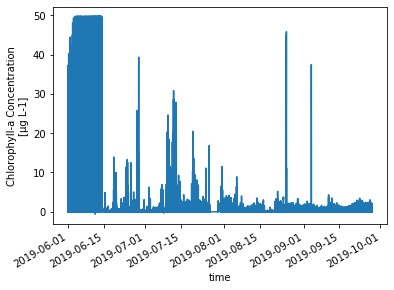

In [44]:
zarrchlor.fluorometric_chlorophyll_a.plot()

In [45]:
# An idea for when these plots take a long time...
# from dask.diagnostics import ProgressBar
# with ProgressBar():
#     zarrchlor.plot.scatter(x='time', y='int_ctd_pressure', hue='fluorometric_chlorophyll_a')

### Relocate this comment 


At a low level parquet breaks data in column-wise storage, many small files. Notice this is column-format, not 
row format as we are accustomed to in CSV files. When you read this into dask... a pandas data frame reads the 
entire file... but dask works on lazy eval so dask access to a parquet data ensemble (many of these small chunked 
files) is very efficient as lazy eval. 


Dask reads this data into a dask data frame (which we can consider virtualized / lazy); and a dask data frame is 
analogous to a pandas data frame with that virtualization. 


Athena gives an analogous end-result; it is an AWS service running Apache Hive under the hood. 
You are charged for every query, beware. The access protocol is a SQL query. 

### Resource code block


This is a 3 x 3 matrix of CTD and related-sensor time series charts from a `data_gallery` IPython notebook. 


```
rn = range(9); rsi = range(7)

p,a=plt.subplots(3, 3, figsize=(14,14))
plt.rcParams.update({'font.size': 10})
a[0,0].plot(ctdF.time, ctdF.depth, color='r');                                  a[0,0].set(ylim=(200.,0.), title='Depth')
a[0,1].plot(ctdF.time, ctdF.salinity, color='k');                               a[0,1].set(title='Salinity')
a[0,2].plot(ctdF.time, ctdF.temperature, color='b');                            a[0,2].set(title='Temperature')
a[1,0].plot(ctdF.time, ctdF.dissolved_oxygen, color='b');                       a[1,0].set(title='Dissolved Oxygen')
a[1,1].scatter(phF.time.values, phF.ph_seawater.values, color='r');             a[1,1].set(title='pH')
a[1,2].scatter(nitrateF.time.values, nitrateF.scn.values, color='k');           a[1,2].set(title='Nitrate')
a[2,0].plot(parF.time, parF.par_counts_output, color='k');                      a[2,0].set(title='Photosynthetic Light')
a[2,1].plot(fluorF.time, fluorF.fluorometric_chlorophyll_a, color='b');         a[2,1].set(title='Chlorophyll')
a[2,2].plot(siF.time, siF.si0, color='r');                                      a[2,2].set(title='Spectral Irradiance')

a[2,0].text(dt64('2017-08-21T07:30'), 155., 'local midnight', rotation=90, fontsize=15, color='blue', fontweight='bold')
a[2,2].text(dt64('2017-08-21T07:30'), 4.25, 'local midnight', rotation=90, fontsize=15, color='blue', fontweight='bold')

tFmt   = mdates.DateFormatter("%H")                 # an extended format for strftime() is "%d/%m/%y %H:%M"
t0, t1 = ctdF.time[0].values, ctdF.time[-1].values  # establish same time range for each chart
tticks = [dt64('2017-08-21T06:00'), dt64('2017-08-21T12:00'), dt64('2017-08-21T18:00')]

for i in rn: j, k = i//3, i%3; a[j, k].set(xlim=(t0, t1),xticks=tticks); a[j, k].xaxis.set_major_formatter(tFmt)
print('')
```

In [46]:
# Two ways of stipulating time slice arguments for a Dataset .sel()
#   First uses a datetime64 and is precise to minutes (or finer)
#   Second passes strings that are interpreted as days, inclusive
#
# if do_precision:  
#    t0 = dt64('2019-06-01T00:00')
#    t1 = dt64('2019-06-01T05:20')
#    dss = ds.sel(time=slice(t0, t1))   
# else:
#     day1 = '24'
#     day2 = '27'              # will be 'day 27 inclusive' giving four days of results
#     dss = ds.sel(time=slice('2019-06-' + day1, '2019-08-' + day2))
# len(dss.time)